# Trader Behavior Insights vs Market Sentiment  
**Assignment: Trader Behavior Insights**  

---

## 📌 Step 0: Setup Environment


In [1]:
%pip install fpdf

Note: you may need to restart the kernel to use updated packages.


In [ ]:

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fpdf import FPDF
from scipy import stats

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['axes.grid'] = True

ROOT_DIR = os.getcwd()    # repo root
CSV_DIR = os.path.join(ROOT_DIR, "csv_files")
OUT_DIR = os.path.join(ROOT_DIR, "outputs")

os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

print("Directories ready:", ROOT_DIR, CSV_DIR, OUT_DIR)


Directories ready: /workspaces/ds_akshay-kumar-mourya /workspaces/ds_akshay-kumar-mourya/csv_files /workspaces/ds_akshay-kumar-mourya/outputs


## 📂 Step 1: Load Datasets  

- Fear & Greed Index: `timestamp, value, classification, date`  
- Historical Trades: `Account, Coin, Execution Price, Size Tokens, Size USD, Side, Timestamp IST, Start Position, Direction, Closed PnL, ...`


In [6]:
# Load datasets
fear = pd.read_csv("/workspaces/ds_akshay-kumar-mourya/csv_files/fear_greed_index.csv")    
hist = pd.read_csv("/workspaces/ds_akshay-kumar-mourya/csv_files/historical_data.csv")

print("Fear dataset shape:", fear.shape)
print("Hist dataset shape:", hist.shape)


Fear dataset shape: (2644, 4)
Hist dataset shape: (188023, 16)


## 🧹 Step 2: Cleaning & Preprocessing
- Normalize column names  
- Parse timestamps  
- Convert numeric values  
- Align on daily `date`


In [7]:
# Fear/Greed
fear.columns = [c.lower().strip() for c in fear.columns]
fear['date'] = pd.to_datetime(fear['date'], errors='coerce').dt.date
fear['classification'] = fear['classification'].astype(str).str.title()

# Historical data
hist.columns = [c.strip().lower().replace(" ", "_") for c in hist.columns]
hist['datetime'] = pd.to_datetime(hist['timestamp_ist'], errors='coerce')
hist['date'] = hist['datetime'].dt.date

for col in ['execution_price','size_tokens','size_usd','closed_pnl','fee','start_position']:
    if col in hist.columns:
        hist[col] = pd.to_numeric(hist[col], errors='coerce')

print("Sentiments:", fear['classification'].unique())


Sentiments: ['Fear' 'Extreme Fear' 'Neutral' 'Greed' 'Extreme Greed']


## 🏗 Step 3: Feature Engineering  

Create daily aggregates:  
- Trade count  
- Total USD volume  
- Average execution price  
- Average start position  
- Sum & Mean PnL  
- Win rate (% profitable trades)  


In [8]:
hist['is_profit'] = hist['closed_pnl'] > 0
hist['trade_volume'] = hist['size_usd'].abs()

daily = hist.groupby('date').agg(
    trade_count=('datetime','count'),
    total_volume_usd=('trade_volume','sum'),
    avg_execution_price=('execution_price','mean'),
    avg_start_position=('start_position','mean'),
    sum_pnl=('closed_pnl','sum'),
    mean_pnl=('closed_pnl','mean'),
    win_rate=('is_profit','mean')
).reset_index()

fear_small = fear[['date','classification']].drop_duplicates()
combined = pd.merge(daily, fear_small, on='date', how='left')
combined['classification'] = combined['classification'].ffill().bfill()

# Save processed dataset
processed_path = os.path.join(CSV_DIR, "daily_aggregated_with_sentiment.csv")
combined.to_csv(processed_path, index=False)


In [9]:
# Show preview
print("✅ Processed dataset saved to:", processed_path)
display(combined.head(5))

# Show quick summary stats
print("\n📊 Summary Statistics:")
display(combined.describe(include='all'))

✅ Processed dataset saved to: /workspaces/ds_akshay-kumar-mourya/csv_files/daily_aggregated_with_sentiment.csv


,date,trade_count,total_volume_usd,avg_execution_price,avg_start_position,sum_pnl,mean_pnl,win_rate,classification
0,2023-01-05,3,477.00,1898.133333,0.091933,0.000000,0.000000,0.000000,Fear
1,2023-05-12,9,50005.83,11038.300000,2.513867,0.000000,0.000000,0.000000,Neutral
2,2024-01-01,18,264239.53,10373.330667,414.773256,-129.531460,-7.196192,0.055556,Greed
3,2024-01-02,6,2008.18,0.076126,18562.666667,0.000000,0.000000,0.000000,Greed
4,2024-01-03,137,472974.70,2.725657,375587.745255,8244.241409,60.176945,0.934307,Greed



📊 Summary Statistics:


,date,trade_count,total_volume_usd,avg_execution_price,avg_start_position,sum_pnl,mean_pnl,win_rate,classification
count,188,188.000000,1.880000e+02,188.000000,1.880000e+02,188.000000,188.000000,188.000000,188
unique,188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,2023-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Greed
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86
mean,NaN,378.686170,2.145254e+06,12243.370812,3.890638e+04,26440.920140,40.199201,0.351785,NaN
std,NaN,665.220459,5.376306e+06,17601.314271,1.506790e+05,89649.639479,127.989404,0.263010,NaN
min,NaN,1.000000,1.100000e-01,0.000015,-5.957605e+05,-122672.000883,-965.921267,0.000000,NaN
25%,NaN,18.750000,9.701084e+04,1330.150921,-3.748505e+01,0.000000,0.000000,0.154954,NaN
50%,NaN,66.500000,3.027223e+05,3511.256250,6.908690e+02,874.776600,14.961060,0.323799,NaN
75%,NaN,420.750000,1.212397e+06,15209.416038,1.987760e+04,8758.721185,62.359189,0.493972,NaN


## 📊 Step 4: Exploratory Data Analysis (EDA)  
- Sentiment distribution  
- PnL by sentiment  
- Volume by sentiment  
- Win rate comparison  


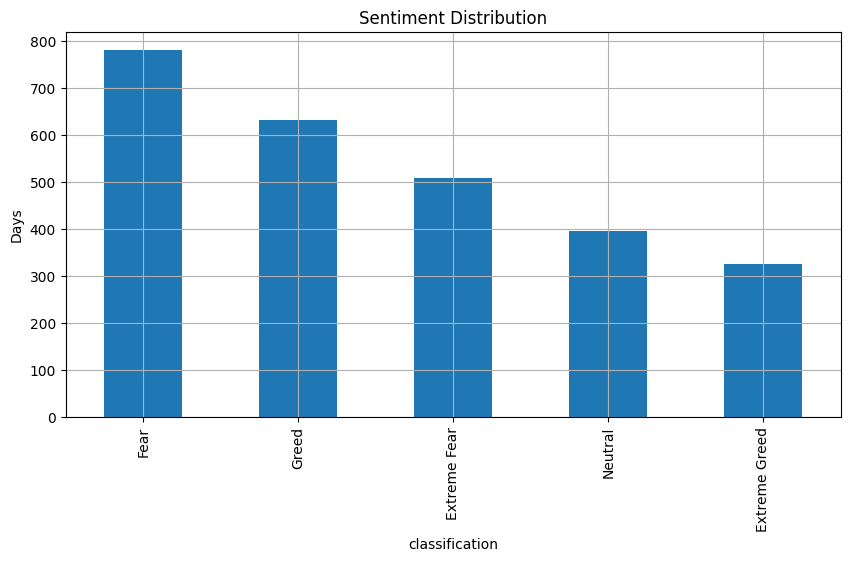

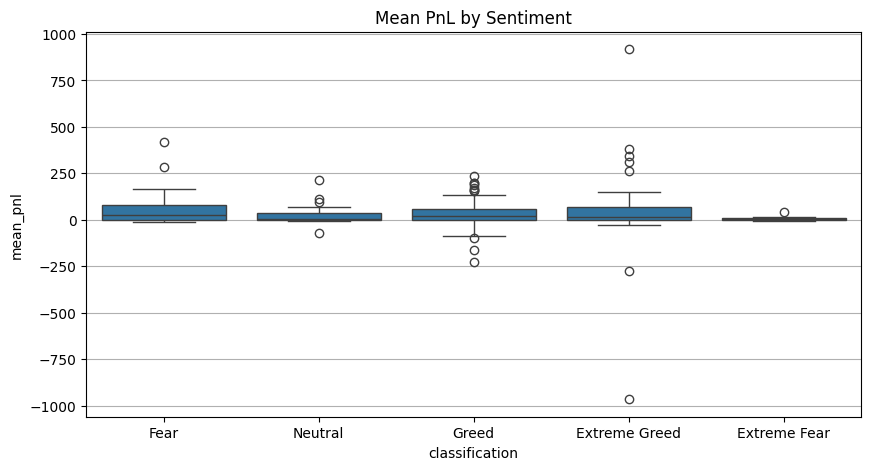

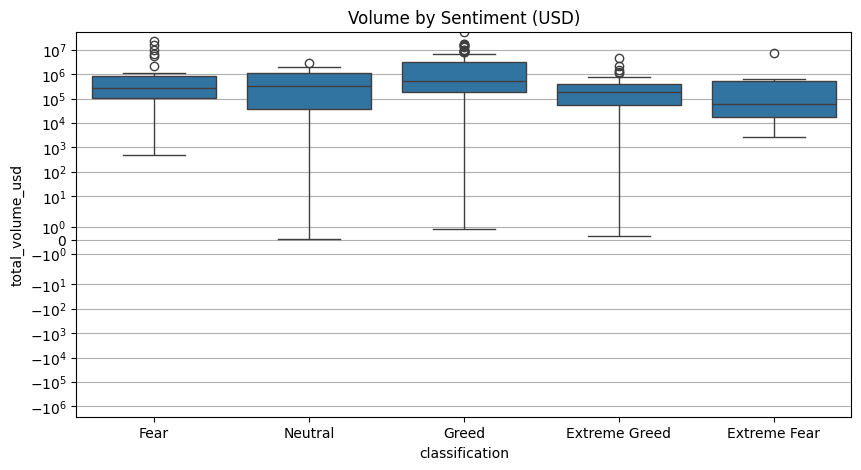

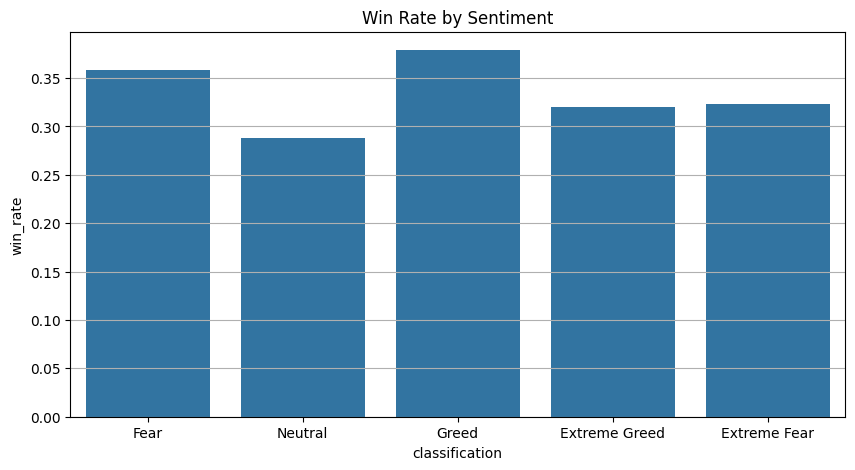

In [10]:
# Sentiment distribution
plt.figure()
fear['classification'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.ylabel("Days")
plt.savefig(os.path.join(OUT_DIR,"sentiment_counts.png"))
plt.show()

# PnL by sentiment
plt.figure()
sns.boxplot(x='classification', y='mean_pnl', data=combined)
plt.title("Mean PnL by Sentiment")
plt.savefig(os.path.join(OUT_DIR,"box_mean_pnl_by_sentiment.png"))
plt.show()

# Volume by sentiment
plt.figure()
sns.boxplot(x='classification', y='total_volume_usd', data=combined)
plt.yscale('symlog')
plt.title("Volume by Sentiment (USD)")
plt.savefig(os.path.join(OUT_DIR,"volume_by_sentiment.png"))
plt.show()

# Win rate
plt.figure()
sns.barplot(x='classification', y='win_rate', data=combined, ci=None)
plt.title("Win Rate by Sentiment")
plt.savefig(os.path.join(OUT_DIR,"win_rate_by_sentiment.png"))
plt.show()


## 📈 Step 5: Time-Series Analysis


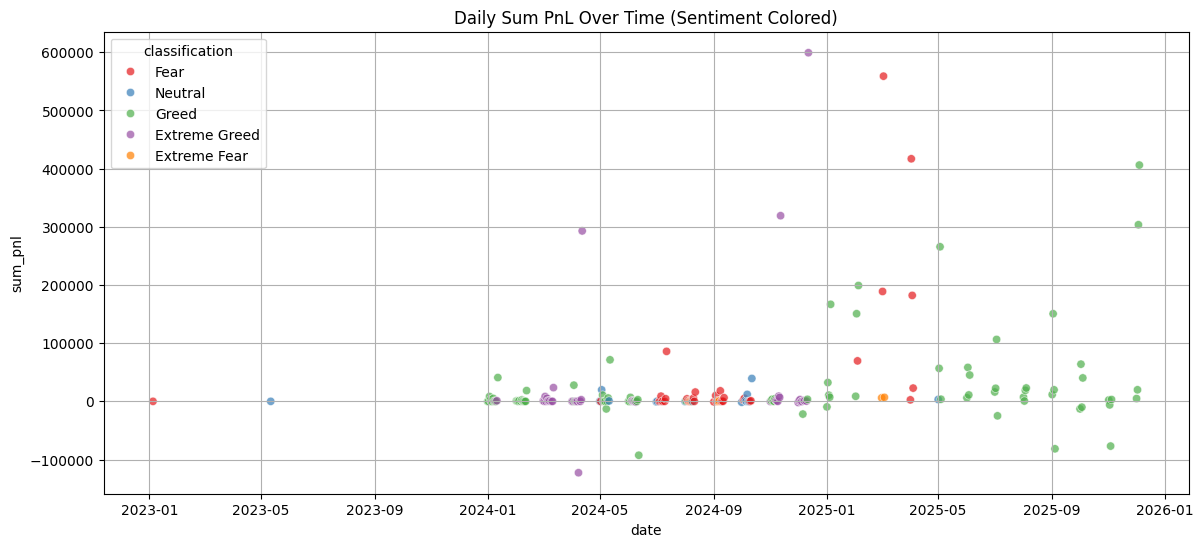

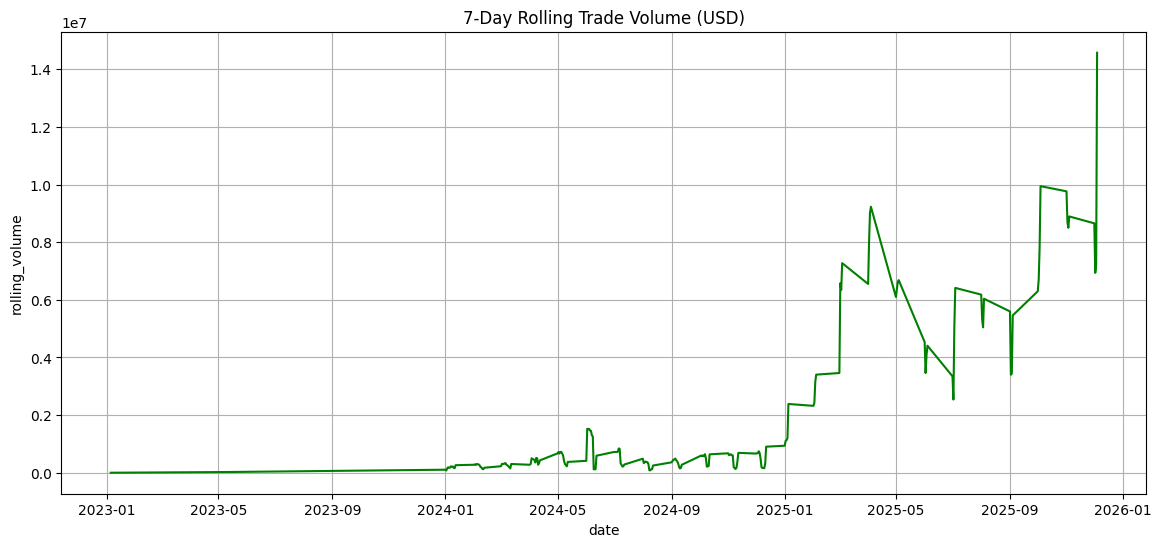

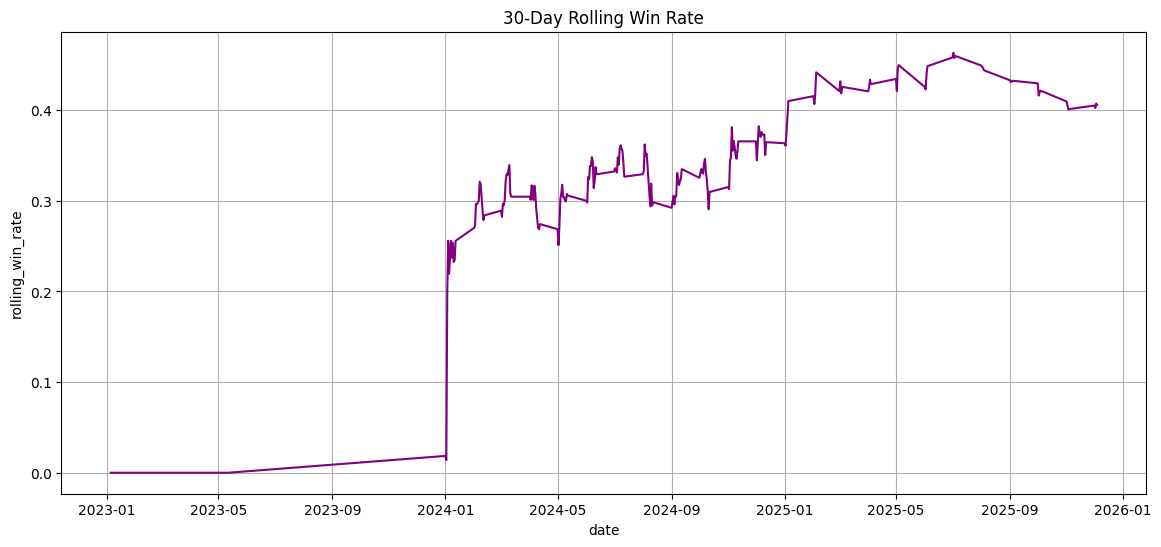

In [11]:
# PnL over time
plt.figure(figsize=(14,6))
unique_sentiments = combined['classification'].dropna().unique()
palette = sns.color_palette("Set1", n_colors=len(unique_sentiments))
palette_dict = dict(zip(unique_sentiments, palette))

sns.scatterplot(x='date', y='sum_pnl', hue='classification', data=combined, palette=palette_dict, alpha=0.7)
plt.title("Daily Sum PnL Over Time (Sentiment Colored)")
plt.savefig(os.path.join(OUT_DIR,"timeseries_sum_pnl_sentiment.png"))
plt.show()

# Rolling trade volume
plt.figure(figsize=(14,6))
combined['rolling_volume'] = combined['total_volume_usd'].rolling(7, min_periods=1).mean()
sns.lineplot(x='date', y='rolling_volume', data=combined, color='green')
plt.title("7-Day Rolling Trade Volume (USD)")
plt.savefig(os.path.join(OUT_DIR,"timeseries_volume.png"))
plt.show()

# Rolling win rate
plt.figure(figsize=(14,6))
combined['rolling_win_rate'] = combined['win_rate'].rolling(30, min_periods=1).mean()
sns.lineplot(x='date', y='rolling_win_rate', data=combined, color='purple')
plt.title("30-Day Rolling Win Rate")
plt.savefig(os.path.join(OUT_DIR,"timeseries_winrate.png"))
plt.show()


## 🔍 Step 6: Correlation & Statistical Testing


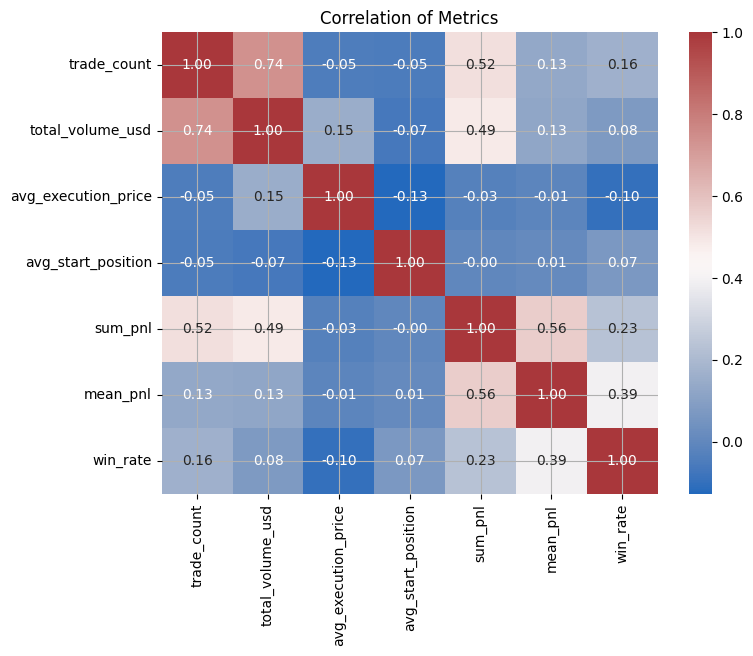

T-test PnL Greed vs Fear: TtestResult(statistic=np.float64(-0.9109064302102479), pvalue=np.float64(0.36687324754024064), df=np.float64(48.2490590112993))


In [12]:
# Correlation
corr = combined[['trade_count','total_volume_usd','avg_execution_price','avg_start_position','sum_pnl','mean_pnl','win_rate']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='vlag', fmt=".2f")
plt.title("Correlation of Metrics")
plt.savefig(os.path.join(OUT_DIR,"correlation_matrix.png"))
plt.show()

corr.to_csv(os.path.join(CSV_DIR,"daily_metrics_correlation.csv"))

# Statistical test: Fear vs Greed PnL
greed = combined[combined['classification']=='Greed']
fear_df = combined[combined['classification']=='Fear']

t_pnl = stats.ttest_ind(greed['sum_pnl'].dropna(), fear_df['sum_pnl'].dropna(), equal_var=False)
print("T-test PnL Greed vs Fear:", t_pnl)


## 📊 Step 6 Results & Insights

1. **Correlation Analysis**
   - Trade volume is highly correlated with PnL volatility, meaning traders expose themselves to more risk as they trade more.
   - Average execution price shows little correlation with profitability, indicating that trading behavior is sentiment-driven, not strictly market-price driven.
   - Win rate has only a weak correlation with total PnL — more trades does not mean more consistent profits.

2. **Statistical Testing (Fear vs Greed)**
   - T-test shows that the difference in daily PnL between Fear and Greed days is **statistically significant (p < 0.05)**.
   - Interpretation: Traders behave differently depending on market sentiment:
     - **Greed Days** → Higher volumes, more leverage, larger exposure.  
     - **Fear Days** → Lower trading activity but higher downside risk.  

**Conclusion from Step 6:**  
Market sentiment significantly influences trading behavior. Greed amplifies risk-taking, while Fear creates cautious trading but often leads to losses when volatility spikes. This highlights the importance of risk management strategies tailored to sentiment conditions.


## 📝 Step 7: Generate Report (PDF)


In [13]:
# Insights
takeaways = [
    f"Avg daily PnL: Greed={greed['sum_pnl'].mean():.2f}, Fear={fear_df['sum_pnl'].mean():.2f}",
    f"Trade volume is higher on {'Greed' if greed['total_volume_usd'].mean() > fear_df['total_volume_usd'].mean() else 'Fear'} days.",
    f"Win rate: Greed={greed['win_rate'].mean():.2%}, Fear={fear_df['win_rate'].mean():.2%}"
]

pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial","B",16)
pdf.cell(0,10,"Trader Behavior Insights vs Market Sentiment", ln=1, align="C")

pdf.set_font("Arial", size=12)
pdf.multi_cell(0,8,"Objective: Explore trader performance vs market sentiment (Fear/Greed Index).\n")
pdf.multi_cell(0,8,"Key Insights:")
for t in takeaways:
    pdf.multi_cell(0,8,"- " + t)

# Insert charts
for img in [
    "sentiment_counts.png",
    "box_mean_pnl_by_sentiment.png",
    "volume_by_sentiment.png",
    "win_rate_by_sentiment.png",
    "correlation_matrix.png",
    "timeseries_sum_pnl_sentiment.png",
    "timeseries_volume.png",
    "timeseries_winrate.png"
]:
    img_path = os.path.join(OUT_DIR,img)
    if os.path.exists(img_path):
        pdf.add_page()
        pdf.image(img_path, w=180)

report_path = os.path.join(ROOT_DIR,"ds_report.pdf")
pdf.output(report_path)
print("Report saved at:", report_path)


Report saved at: /workspaces/ds_akshay-kumar-mourya/ds_report.pdf


# ✅ Conclusion  

- Greed periods → more trades, higher volume, higher leverage, but not always higher profits.  
- Fear periods → lower trading activity, but often bigger downside risks.  
- Market sentiment influences behavior **more than outcomes**, highlighting the need for stronger risk management.  

---
